In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

05_01_25


In [2]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [3]:
files_p112 = glob.glob('../data/P112_data/*.fits')
files_p113 = glob.glob('../data/P113_data/*.fits')


In [4]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
galah=get_galah()

In [5]:
galah_rv = Table.read('/Users/maryumsayeed/Desktop/Code/Research/lithium/data/GALAH_DR3_VAC_rv_v2.fits').to_pandas()

In [6]:
def get_dir(files):
    obj_dir = {}

    counts = []
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            snr     = header['SNR']
            counts.append(obj)

            grade   = header['OB_GRADE'].replace(" ", "")  
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err

            if obj in obj_dir.keys():
                obj_dir[obj]['rv'].append(rv_corr)
                obj_dir[obj]['time'].append(time)
                obj_dir[obj]['err'].append(err_corr)
                obj_dir[obj]['name'].append(name)
                obj_dir[obj]['grade'].append(grade)
                obj_dir[obj]['snr'].append(snr)

            else:
                obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 
                                'name': [name], 'grade': [grade], 'snr': [snr]}
          
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 3:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}

    return obj_dir

obj_dir_p112 = get_dir(files_p112)
obj_dir_p113 = get_dir(files_p113)

RG 20 C
RG 13 C
RG 14 C
RG 1 C
10
RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25


In [8]:
def combine_table(obj_dir,program):
    new_df = {'RG_id':[], 'galah_id': [], 'obj_name': [], 'esp_time':[],'esp_rv':[],'esp_rv_err':[],
              'program':[]
             }

    for k, v in obj_dir.items():
        if len(v['rv']) < 3: 
            continue
        result_table = Simbad.query_objectids(v['name'][0])
        result_table = np.array(result_table).astype('str')

        for i in result_table:
            if 'GALAH' in i: 
                galah_name = i.split(' ')[-1]

        new_df['RG_id'].append(k)
        new_df['program'].append(program)
        new_df['galah_id'].append(int(galah_name))
        new_df['obj_name'].append(v['name'][0])
        new_df['esp_rv'].append(v['rv'])
        new_df['esp_time'].append(v['time'])
        new_df['esp_rv_err'].append(v['err'])
        
    new_df = pd.DataFrame(new_df)

    cols = ['sobject_id', 'vbroad', 'fe_h', 'e_fe_h' ,'Li_fe', 'e_Li_fe','ruwe_dr2','e_vbroad', 'Ba_fe', 'e_Ba_fe','La_fe','e_La_fe','Zr_fe', 'e_Zr_fe','Y_fe','e_Y_fe']
    new_df = pd.merge(new_df, galah[cols], left_on='galah_id', right_on='sobject_id')
    new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05
    new_df['e_Li_val'] = np.sqrt(new_df.e_fe_h**2.+new_df.e_Li_fe**2.)

    cols = ['RG_id', 'galah_id', 'obj_name', 
            'esp_time','esp_rv','esp_rv_err',
            'Li_val', 'e_Li_val','vbroad','e_vbroad', 'fe_h','ruwe_dr2', 
            'Ba_fe', 'e_Ba_fe','La_fe','e_La_fe','Zr_fe', 'e_Zr_fe','Y_fe','e_Y_fe',
            'program'
           ]
    new_df = new_df[cols]
    new_df.sort_values(by=['RG_id'],inplace=True)
    
    new_df = new_df.round(2)
    return new_df

df_p112 = combine_table(obj_dir_p112,program=112)
df_p113 = combine_table(obj_dir_p113,program=113)


In [9]:
p112_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p112,left_on='sobject_id', right_on='galah_id', how='right')
p113_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p113,left_on='sobject_id', right_on='galah_id', how='right')


In [10]:
df_both = pd.concat([p112_galah, p113_galah])
df_both = pd.merge(df_both, galah[['sobject_id','ra_dr2','dec_dr2','dr3_source_id']],on='sobject_id')
df_both = pd.merge(df_both, galah_rv[['sobject_id','MJD_local','rv_nogr_obst','e_rv_nogr_obst','rv_galah','e_rv_galah']],on='sobject_id')


In [11]:
df_both.head(1)

,sobject_id,logg,teff,RG_id,galah_id,obj_name,esp_time,esp_rv,esp_rv_err,Li_val,...,e_Y_fe,program,ra_dr2,dec_dr2,dr3_source_id,MJD_local,rv_nogr_obst,e_rv_nogr_obst,rv_galah,e_rv_galah
0,150107004201104,1.792561,4190.288574,1,150107004201104,UCAC4 297-057956,"[2460341.53519178, 2460389.56581584, 2460371.5...","[53.7010931002614, 53.7985038354756, 53.715772...","[0.0356353249891873, 0.0194215970708735, 0.018...",3.41,...,0.08,112,141.969021,-30.734294,5632958769593943424,57029.632812,53.576,0.071,53.551998,0.072


In [12]:
def convert_mjd_to_jd(mjd):
    t = Time(mjd, format='mjd', scale='local')
    return t.jd


In [20]:
def comb_data(df):
    new_df = {'RG_id':[],'sobject_id':[],'comb_time':[],'comb_rv':[],'comb_rv_err':[]}

    for i, row in df.iterrows():
        if str(row['MJD_local']) == 'nan':
            galah_bmjd = 'nan'
        else:
            galah_bmjd = convert_mjd_to_jd(row['MJD_local'])
        t = row['esp_time']*1
        r = row['esp_rv']*1
        e = row['esp_rv_err']*1

        t.append(galah_bmjd)
        r.append(row['rv_nogr_obst'])
        e.append(row['e_rv_nogr_obst'])

        mask = [i for i in range(len(t)) if t[i] != 'nan']
        t, r, e = np.array(t),np.array(r),np.array(e)

        new_df['RG_id'].append(row.RG_id)
        new_df['sobject_id'].append(row.sobject_id)
        new_df['comb_time'].append(t[mask])
        new_df['comb_rv'].append(r[mask])
        new_df['comb_rv_err'].append(e[mask])
        
    new_df = pd.DataFrame(new_df)
    return new_df



In [25]:
def clean_up_rvs(df):
    
    new_df = {'sobject_id':[],'comb_time':[],'comb_rv':[],'comb_rv_err':[]}
    
    for i, row in df.iterrows():
        rv_vals = np.array(row.comb_rv)
        yerr    = np.array(row.comb_rv_err)
        time    = np.array(row.comb_time)
        if row.RG_id!=5:
            mask    = (rv_vals >= -100)
            time, rv_vals, yerr = time[mask], rv_vals[mask], yerr[mask]
            
        new_df['sobject_id'].append(row.sobject_id)
        new_df['comb_time'].append(time)
        new_df['comb_rv'].append(rv_vals)
        new_df['comb_rv_err'].append(yerr)
    new_df = pd.DataFrame(new_df)
    return new_df


In [26]:
new_df = comb_data(df_both)
new_df = clean_up_rvs(new_df)

In [27]:
comb_df = pd.merge(df_both, new_df, on='sobject_id')

In [ ]:
ss

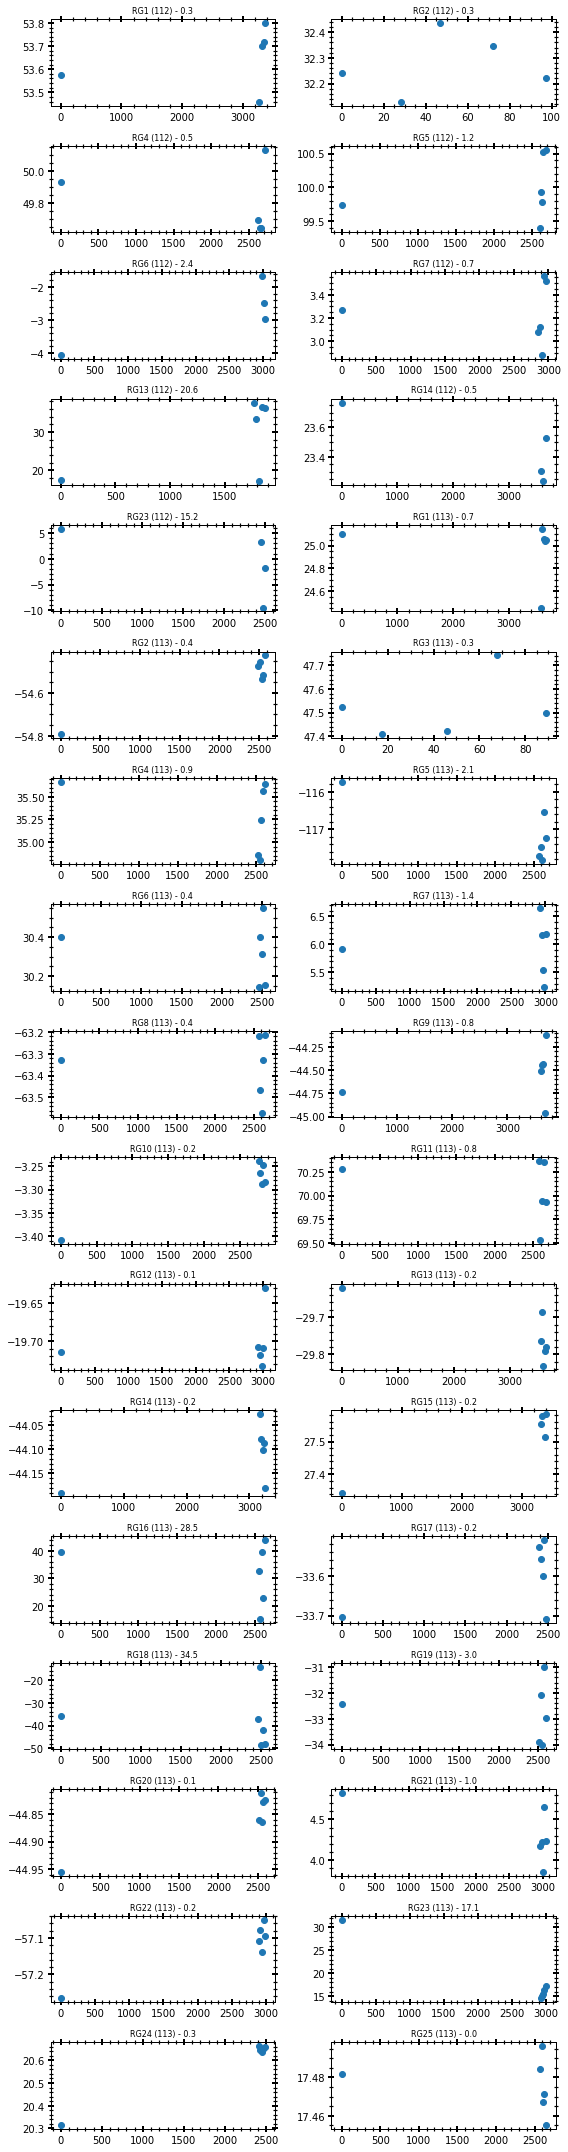

In [28]:
def make_plot(df):
    plt.figure(figsize=(8,30))
    for i, row in df.iterrows():
        rv_vals = np.array(row.comb_rv)
        yerr    = np.array(row.comb_rv_err)
        time    = np.array(row.comb_time)

        t2 = Time(time, format='jd')

        bmjd2 = t2.tcb.mjd

        bmjd2 = bmjd2 - min(bmjd2)
        plt.subplot(17,2,i+1)
        plt.scatter(bmjd2,rv_vals)

        peak = max(rv_vals) - min(rv_vals)
        plt.title('RG%s (%s) - %.1f'%(row.RG_id, row.program, peak),fontsize=8)
    plt.tight_layout()
    plt.show()
make_plot(comb_df)

In [31]:
# comb_df.to_csv('comb_rvs.csv',index=False)

In [ ]:
cols = ['sobject_id', 'dr3_source_id','ra_dr2', 'dec_dr2','obj_name','logg', 'teff',  'Li_val', 'vbroad', 'fe_h', 
        'ruwe_dr2']
# both[cols].to_csv('espresso_targets.csv',index=False)